<a href="https://colab.research.google.com/github/SelimSavas/low-light-segmentation-with-mirnet-yolov8-segment-anything/blob/main/MIRNetandYOLOv8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLOv8 vs SAM Meta

## Library

In [ ]:
!pip install ultralytics
!pip install supervision
!pip install roboflow

import numpy as np
import cv2
import os
import sys
import torch
from roboflow import Roboflow

import random
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
from tensorflow import keras

# Özel kayıp işlevini yeniden tanımlayın
def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))


def peak_signal_noise_ratio(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=255.0)


# MirNet modelinizi yükleyin ve custom_objects argümanına özel kayıp işlevinizi geçin
mirnet_model = keras.models.load_model('/content/drive/MyDrive/mirnet_model.h5', custom_objects={'charbonnier_loss': charbonnier_loss,'peak_signal_noise_ratio':peak_signal_noise_ratio})


In [4]:
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
%cd {HOME}

!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

In [6]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_l"

In [ ]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth

In [8]:
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_l_0b3195.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_l_0b3195.pth ; exist: True


In [9]:
low_light_image = Image.open('/content/dalton-smith-LXHwWziV3eg-unsplash.jpg')
low_light_image = low_light_image.resize((1200,800),Image.NEAREST)
low_light_image = np.uint32(low_light_image)
low_light_image.shape

(800, 1200, 3)

In [10]:
image = keras.preprocessing.image.img_to_array(low_light_image)
image = image.astype('float32') / 255.0
image = np.expand_dims(image, axis = 0)
image = mirnet_model.predict(image)
image = image[0] * 255.0
image = image.clip(0,255)
image = image.reshape((np.shape(image)[0],np.shape(image)[1],3))
image = np.uint32(image)
image.shape

1/1 [==============================] - 28s 28s/step


(800, 1200, 3)

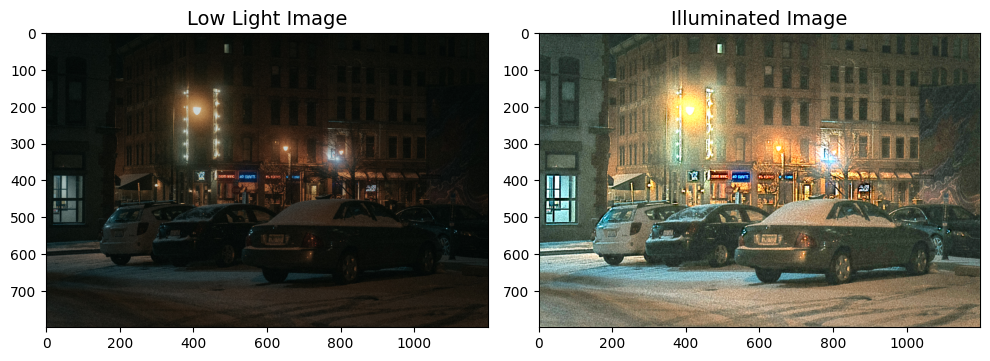

In [11]:
# Görüntülerinizi ayrı ayrı birer dizi olarak saklayın
images = [low_light_image, image]

# Başlık dizisi oluşturun
titles = ['Low Light Image', 'Illuminated Image']

# Görüntülerinizi 2x2 bir ızgara içinde gösterin
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
for idx, ax in enumerate(axes.ravel()):
    if idx < len(images):
        ax.imshow(images[idx])
        ax.set_title(titles[idx], fontsize=14)
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

## YoloV8 - Creating BBox

In [12]:
from ultralytics import YOLO

yolo_model = YOLO('yolov8x.pt')

results = yolo_model.predict(source=low_light_image.astype(np.uint8))

boxes_class_name = np.array([])
for r in results:
    for c in r.boxes.cls:
        boxes_class_name = np.append(boxes_class_name,yolo_model.names[int(c)])

k = 0
result_np_son = np.array([])
result_class = np.array([])
result_score = np.array([])
for result in results:
    result_np = np.array(result.boxes.data.cpu())

for i in result_np:
    result_np_son = np.append(result_np_son,i[:][:-2])
    result_class = np.append(result_class,i[:][-1:])
    result_score = np.append(result_score,i[:][-2:-1])
    k += 1


boxes = result_np_son.reshape((k,4))
boxes_class = result_class.reshape((k,))
boxes_score = result_score.reshape((k,))

100%|██████████| 131M/131M [00:02<00:00, 59.2MB/s]

0: 448x640 4 cars, 1 traffic light, 260.3ms
Speed: 34.2ms preprocess, 260.3ms inference, 48.9ms postprocess per image at shape (1, 3, 640, 640)


In [13]:
boxes

array([[     530.31,      451.49,      1080.2,      682.78],
       [     145.15,       457.7,      407.79,      632.48],
       [      286.6,      463.84,      625.45,      638.41],
       [     949.21,      464.99,      1199.9,      607.67],
       [     785.92,       274.6,      814.31,      336.89]])

In [15]:
low_light_image = low_light_image.astype(np.uint8)
low_segmented_image = low_light_image.copy()
low_box_image = low_light_image.copy()
boxes_class_value = {'0':sv.Color.white(),'2':sv.Color.blue(),'4':sv.Color.red(),'5':sv.Color.blue() ,'7':sv.Color.black(),'8':sv.Color.green(),'9':sv.Color.blue()}
mask_predictor.set_image(low_light_image)

boxes = result.boxes.xyxy
print('Shape of boxes array:', boxes.shape)
print('Size of boxes array:', boxes.size)
print(boxes)

Shape of boxes array: torch.Size([5, 4])
Size of boxes array: <built-in method size of Tensor object at 0x7feb52f91170>
tensor([[ 530.3116,  451.4913, 1080.2394,  682.7806],
        [ 145.1518,  457.6978,  407.7917,  632.4796],
        [ 286.6011,  463.8420,  625.4547,  638.4129],
        [ 949.2082,  464.9873, 1199.8677,  607.6747],
        [ 785.9167,  274.5960,  814.3051,  336.8883]], device='cuda:0')


In [16]:
boxes.shape[0]

5

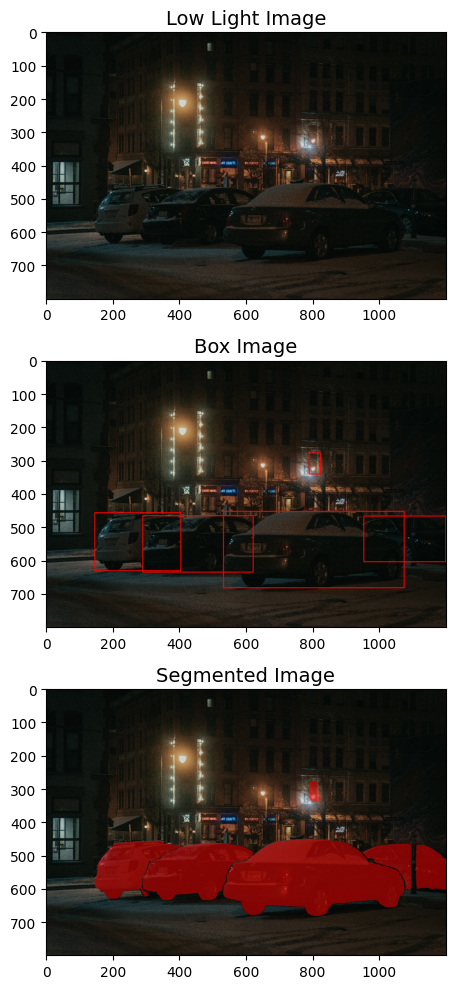

In [17]:
masks, scores, logits = mask_predictor.predict_torch(
    point_coords = None,
    point_labels = None,
    boxes = boxes * 1040/max(low_light_image.shape),
    multimask_output=True
)

masks = masks.cpu().numpy()

i = 0
for box in boxes.cpu().numpy():

    box_annotator = sv.BoxAnnotator(color= boxes_class_value[str(int(boxes_class[i]))], text_padding=10)
    mask_annotator = sv.MaskAnnotator(color= boxes_class_value[str(int(boxes_class[i]))])

    detections = sv.Detections(
        xyxy=sv.mask_to_xyxy(masks=masks[i]),
        mask=masks[i]
    )
    
    detections = detections[detections.area == np.max(detections.area)]
    low_box_image = box_annotator.annotate(scene=low_box_image, detections=detections, skip_label=True)
    low_segmented_image = mask_annotator.annotate(scene=low_segmented_image, detections=detections)
    i += 1

# Görüntülerinizi ayrı ayrı birer dizi olarak saklayın
images = [low_light_image,low_box_image, low_segmented_image]

# Başlık dizisi oluşturun
titles = ['Low Light Image','Box Image', 'Segmented Image']

# Görüntülerinizi 2x2 bir ızgara içinde gösterin
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,10))
for idx, ax in enumerate(axes.ravel()):
    if idx < len(images):
        ax.imshow(images[idx])
        ax.set_title(titles[idx], fontsize=14)
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

In [18]:
from ultralytics import YOLO

yolo_model = YOLO('yolov8x.pt')
results = yolo_model.predict(source=image.astype(np.uint8))

boxes_class_name = np.array([])
for r in results:
    for c in r.boxes.cls:
        boxes_class_name = np.append(boxes_class_name,yolo_model.names[int(c)])

k = 0
result_np_son = np.array([])
result_class = np.array([])
result_score = np.array([])
for result in results:
    result_np = np.array(result.boxes.data.cpu())

for i in result_np:
    result_np_son = np.append(result_np_son,i[:][:-2])
    result_class = np.append(result_class,i[:][-1:])
    result_score = np.append(result_score,i[:][-2:-1])
    k += 1


boxes = result_np_son.reshape((k,4))
boxes_class = result_class.reshape((k,))
boxes_score = result_score.reshape((k,))


0: 448x640 4 cars, 72.0ms
Speed: 2.8ms preprocess, 72.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


In [19]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import supervision as sv

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

mask_predictor = SamPredictor(sam)

In [20]:
image = image.astype(np.uint8)
segmented_image = image.copy()
box_image = image.copy()
boxes_class_value = {'0':sv.Color.white(),'2':sv.Color.blue(),'4':sv.Color.red(),'5':sv.Color.blue() ,'7':sv.Color.black(),'8':sv.Color.green()}
image_array = np.array(image)
mask_predictor.set_image(image_array)

boxes = result.boxes.xyxy
print('Shape of boxes array:', boxes.shape)
print('Size of boxes array:', boxes.size)
print(boxes)

Shape of boxes array: torch.Size([4, 4])
Size of boxes array: <built-in method size of Tensor object at 0x7feb525050d0>
tensor([[ 530.9503,  452.4704, 1080.1766,  684.8197],
        [ 285.9946,  464.0556,  625.5469,  638.8189],
        [ 143.5593,  458.6399,  404.7363,  632.6860],
        [ 949.9951,  464.3723, 1199.6213,  609.7120]], device='cuda:0')


In [21]:
masks, scores, logits = mask_predictor.predict_torch(
    point_coords = None,
    point_labels = None,
    boxes = boxes * 1040/max(image.shape),
    multimask_output=True
)

masks = masks.cpu().numpy()

i = 0
for box in boxes.cpu().numpy():

    box_annotator = sv.BoxAnnotator(color= boxes_class_value[str(int(boxes_class[i]))], text_padding=10)
    mask_annotator = sv.MaskAnnotator(color= boxes_class_value[str(int(boxes_class[i]))])

    detections = sv.Detections(
        xyxy=sv.mask_to_xyxy(masks=masks[i]),
        mask=masks[i]
    )
    
    detections = detections[detections.area == np.max(detections.area)]
    box_image = box_annotator.annotate(scene=box_image, detections=detections, skip_label=True)
    segmented_image = mask_annotator.annotate(scene=segmented_image, detections=detections)
    i += 1


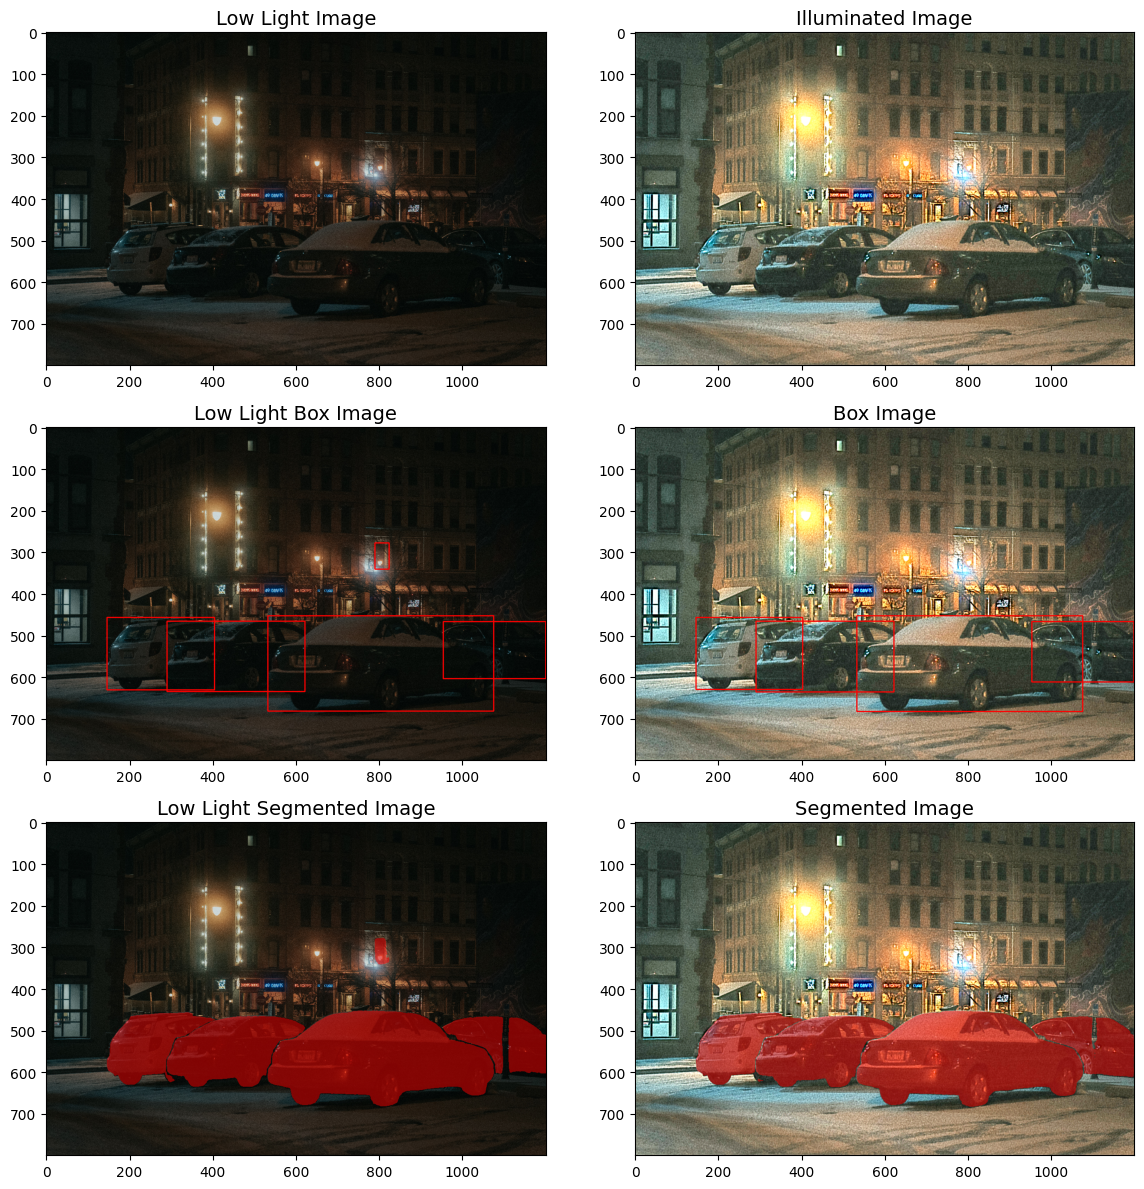

In [25]:

# Görüntülerinizi ayrı ayrı birer dizi olarak saklayın
images = [low_light_image, image, low_box_image,box_image, low_segmented_image, segmented_image]

# Başlık dizisi oluşturun
titles = ['Low Light Image', 'Illuminated Image', 'Low Light Box Image','Box Image', 'Low Light Segmented Image', 'Segmented Image' ]

# Görüntülerinizi 2x2 bir ızgara içinde gösterin
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,12))
for idx, ax in enumerate(axes.ravel()):
    if idx < len(images):
        ax.imshow(images[idx])
        ax.set_title(titles[idx], fontsize=14)
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()